# Convection-Diffusion Equation 1D

# Case 1: Forward Scheme for the convective term

We try to approximate the solution of
\begin{align}
\partial_t u - \nu \partial^2_{xx} u + b \partial_{x} &= f \quad\text{in } \Omega=(a,b) \times (0,T),
\\
\partial_t u \cdot n &= 0\quad\text{on } \partial\Omega,
\end{align}
where $(a,b)\subset\mathbb{R}$ is an interval, $T>0$ is a given final time and $f\in C([a,b] \times (0,T))$.

Let us consider the mesh $x_i=a+h i$, for  $i=0,...,n+1$, with $h=(b-a)/(n+2)$, and the time partition $t_m = km$, $m=0,...,M$ whith $k=T/M$.

We define the problem: given $u_{i,j}^{m-1}$, $m\ge 1$, find $u_{i}^m \simeq u(x_i, t_m)$ such that

$$
\frac 1 k u_{i}^m 
- \nu \frac{ u_{i+1}^m - 2u_{i}^m + u_{i-1}^m}{h^2}
=
f^m_{i} + \frac 1 k u_{i}^{m-1},
$$
or
$$
\Big(\frac 1 k + \frac{2\nu}{h^2}\Big) u_{i}^m 
- \frac{\nu}{h^2} u_{i+1}^m
- \frac{\nu}{h^2} u_{i-1}^m
=
f^m_{i} + \frac 1 k u_{i}^{m-1},
$$
or
$$
\big(1+ 2 \frac {k\nu}{h^2} + b \frac{k}{h} \big) u_{i}^m 
- \big( \frac {k\nu}{h^2} + b \frac{k}{h} \big) u_{i+1}^m
- \frac {k\nu}{h^2} \, u_{i-1}^m
=
k f^m_{i} + u_{i}^{m-1},
$$

It can be written as the system
$AU=F$ with 

\begin{aligned}
U=( u^m_{1},u^m_{2},...,u^m_{n}),
\\
F_{i}=k f^m_{i} + u_{i}^{m-1}
\end{aligned}
and
$$
A=
\begin{pmatrix}
   a & -b &  0 &  0 & \dots & & & 0 & 0 \\
  -c &  a & -b &  0 & \dots & & & 0 & 0\\
   0 & -c &  a & -b & \dots & & & 0 & 0 \\
   \vdots &    & \ddots & \ddots & \ddots & \\
   0 & 0 & \dots & -c & a  & -b \\
   0 & 0 &  0 & \dots & -c & a  & -b \\
     & & &&    & \ddots & \ddots & \ddots & \\
   0 & \dots & &  & & & 0 & a & -b \\ 
   0 & \dots & &  & & &  & -c & a \\
 \end{pmatrix},
$$
siendo:
\begin{align*}
  a&= 1 + 2\frac {k\nu}{h^2}+conv \frac{k}{h}, \\
  b&=\frac {k\nu}{h^2} + conv \frac{k}{h}, \\
  c&=\frac {k\nu}{h^2}.
\end{align*}
El vector diagonal $(d,d,\dots,d)$ está separado exactamente $n$
posiciones desde la diagonal de la matriz.


#### Boundary conditions

Let $\Gamma_l=\{a\}$, $\Gamma_r=\{b\}$. Homogeneous Neumann b.c. can be approximated as follows:

* On $\Gamma_l$: $\partial_x u(a,t_m) \cdot n = \partial_x u(a,t_m) \cdot (-1) = -\partial_x   u(a,t_m) \simeq -\frac{u^m_{1}-u^m_{0}}{h}=0$,
* On $\Gamma_r$: $\nabla u(b,y_j,t_m) \times n = \nabla u(b,y_j,t_m) \times (1,0) = \partial_x   u(b,y_j,t_m) \simeq \frac{u^m_{n+1,j}-u^m_{n,j}}{h}=0$,

Then, boundary conditions can be approximated by defining, for each $m\ge 1$, the values $u^m_{0,j}=u^m_{1,j}$, $u^m_{n+1,j}=u^m_{n,j}$, $u^m_{i,0}=u^m_{i,1}$, $u^m_{i,n+1}=u^m_{i,n}$, $i,j=0,\dots,n+1$

In [1]:
import numpy as np
import matplotlib.pyplot as mpl
from numpy import diag, ones, linspace, array, reshape
from numpy.linalg import solve

In [2]:
def convection_diffusion_equation_neumann_1d(f, u_init, nx_intervals=10, nt_intervals=2, 
                             a=0, b=1, T=1, nu=1, verbosity=0, conv=5):
    """
    Heat equatin with Homogeneous Neumann Boundary Conditions.
    * f: RHS
    * u_init: Initial function, u_init(x)
    * nu: Viscosity coefficient
    * a, b: interval (domain = (a,b))
    * T: Max. time (time interval = (0,T))
    * nx: space discretization, a=x_0,x_1,...,x_{nx}=b$
    * nt: time discretization, 0=t_0,t_1,...,t_{nt}=T$
    * conv: convective coefficient
    """
    
    # Space and time discretization
    nx_points = nx = nx_intervals+1
    h = (b-a)/nx_intervals # Space mesh size
    x = linspace(a, b, nx_points) # a = x_0, ..., x_{nx} = b
    
    k = T/nt_intervals # Time step
    t = linspace(0, T, nt_intervals+1) # 0 = t_0, t_1, ..., t_{nt} = T  

    if(verbosity>1):
        print("x=",x)
        print("t=",t)
    
    c0 = 1 + 2*(k*nu)/h**2 + conv*(k)/(h)  # Diagonal coefficient a_{ii}
    c1 = k*nu/h**2 + conv*(k)/(h)        # -c1 are the extra-diagonal coefficients
    c2 = k*nu/h**2
    
    # Matrix
    n=nx  # n_interior_x_points*n_interior_x_points
    ones0 = ones(n)
    ones1 = ones(n-1)
    A = c0 * diag( ones0 ) \
            - c1 * diag( ones1, +1 ) \
            - c2 * diag( ones1, -1 )

    # Set Neumann boundary c.
    A[0,0] = A[-1,-1] = 1
    A[0,1] = A[-1,-2] = -1
    
    if(verbosity>0): 
        print("nx=%i (h=%2.2f), nt=%i (k=%2.2f), n=(nx+1)^2=%i" % 
              (nx, h, nt_intervals, k, n) )
        print("A=\n", A, " ", end="" )
        print( np.shape(A) )
    
    # Time iterations)
   
    U0 = u_init(x)
    if(verbosity>0):        
        print("U0 =", U0, " ", np.shape(U0) )    
    solution = [ U0 ]

    for m in range(1,nt_intervals+1):  # m=1, 1,..., nt
        current_t = t[m]
        if(verbosity>0):
            print("m=%i, current_t=%.2f" % (m,current_t))
        
        F = k*f(x, current_t) + U0
        
        # Set homogneous Neumann boundary c.
        F[0] = F[-1] = 0
      
        if(verbosity>0):        
            print("F=", F, " ", end="" )
            print( np.shape(F) )

        # 3. Resolver sistema
    
        U = solve(A, F)
        if(verbosity>0):        
            print("U =", U, " ", np.shape(U) )
            from numpy import linalg as LA
            print("||U||_2 =", LA.norm(U))
        U0 = U
        solution.append(U)
        
    return solution, x, t

Define plotting function, RHS function f and initial condition

We provide two initial conditions for testing:
1. $u_0(x) = C$ (constant). The exact solution is $u(x,t)=u_0$ for all $t>0$.
2. $u_0(x) \ge 0$ is defined as a Gaussian (bell) function. Like for any initial condition, the function must converge (in $L^2$ norm) to a constant, $C_\infty\ge 0$, when $t\to\infty$. Specifically, it is not diffcult to show that
$
\| u(t) - u_0 \|_{L^2(\Omega)} \to 0
$
as $t\to\infty$, where $u_\infty$ is the mean oif $u$ in $\Omega$, i.e.
$$
u_\infty= \frac 1{|\Omega|} \int_\Omega u_0(x) dx \in\mathbb R
$$
where $|\Omega|$ is the meassure of $\Omega$.

In [3]:
def my_plot(x, y, t_iter):
    d = t_iter
    l = "$u(x,t_i),\quad i=%i$" % (t_iter)
    mpl.plot(x, y, lw=2, dashes=(5, d), label=l)
    
mpl.rcParams['figure.dpi'] = 100

# --------------------------------------------    
f = lambda x, t: np.zeros_like(x)

# Initial solution 1: u_0=cte (then u(x,t)=cte forall t>0)
u_cte = lambda x: 5*np.ones_like(x)

# Initial solution 2: u_0 = Gaussian function
C_gauss = 10
u_gauss = lambda x: np.exp(-C_gauss*(x**2))

In [4]:
#from scipy import integrate

NameError: name 'quad' is not defined

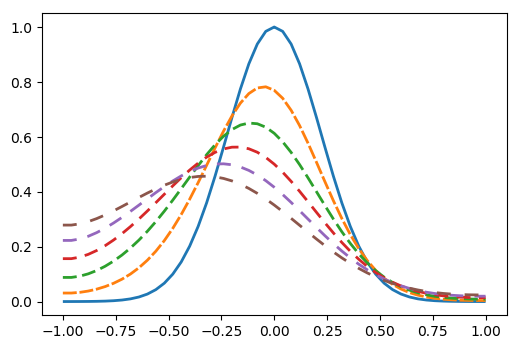

In [5]:
NT = 6
NX = 50
X0 = -1
X1 = 1
u, x, t = convection_diffusion_equation_neumann_1d(f, u_init=u_gauss, 
                                    nx_intervals=NX, nt_intervals=NT, 
                                    a=X0, b=X1, T=0.1, verbosity=0)

for i in range(NT):
    my_plot(x, u[i], i)
    #mpl.show()
u_infty = quad(u[0], x)/(X1-X0) # Media de u_0 en [a,b]
mpl.plot(x, u_infty*np.ones_like(x), "-.", label="$u_\infty$")
mpl.grid()    
mpl.legend()

### Compruebo que $\|u(i)-u_\infty\| \to 0$

In [89]:
def quad(y, x):
    """
    Fórmula de cuadratura de los trapecios compuesta para aproximar la integral
    de la función dada por los valores y_0, y_1, ..., y_{n-1} sobre los 
    nodos x_0, x_1,... x_{n-1}
    """
    h = x[1]-x[0]
    sum = np.sum(y[1:-2]) # f(x_1) + ... + f(x_{n-2})
    return h*( y[0]/2 + sum + y[-1]/2 )

# Test: integral de f(x)=1
valores_y = np.ones_like(x) # Array [1,1,1....1] (del tamaño de x)
integral_aprox = quad(valores_y, x )

print(" Intervalo [%.2f,%.2f], aproximación de la integral de f(x)=1:  %f" 
     % (x[0], x[-1], integral_aprox))

 Intervalo [-1.00,1.00], aproximación de la integral de f(x)=1:  1.960000


In [90]:
a, b = X0, X1
u_infty = quad(u[0], x)/(b-a) # Media de u_0 en [a,b] 

print("Mean of u_infty: %.16f" % (u_infty) )
errores_L2 = []
for i in range(0,NT):
    error_L2_cuadrado = quad( (u[i]-u_infty)**2, x)
    error_L2 = np.sqrt( error_L2_cuadrado )
    print ("||u(t_%i) - u_infty|| =  %.16f " % (i, error_L2) )
    errores_L2.append( error_L2 )
    
mpl.plot(range(NT), errores_L2, lw=3, label="||u(t_i) - u_infty||")
mpl.legend()
mpl.grid()

Mean of u_infty: 0.2802452818146038
||u(t_0) - u_infty|| =  0.4859180965609566 
||u(t_1) - u_infty|| =  0.3936081284289104 
||u(t_2) - u_infty|| =  0.3274962702323725 
||u(t_3) - u_infty|| =  0.2761433282471052 
||u(t_4) - u_infty|| =  0.2343811858294919 
||u(t_5) - u_infty|| =  0.1995846490933039 
